# Задание 1
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей


Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?

In [1]:
""" импортируем все нужные библиотеки"""

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm

In [2]:
""" загружаем нужные данные"""

group = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/final_project/Проект_2_groups.csv', sep=';')
groups_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/final_project/Проект_2_group_add.csv', sep=',')
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/final_project/Проект_2_active_studs.csv', sep=',')
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/final_project/Проект_2_checks.csv', sep=';')

In [3]:
""" Предобработка и анализ тек данных """

group.head()
group.count()
group.isna().sum()
group.dtypes

groups_add.head()
groups_add.count()
groups_add.isna().sum()
groups_add.dtypes

active_studs.head()
active_studs.count()
active_studs.isna().sum()
active_studs.dtypes

checks.head()
checks.count()
checks.isna().sum()
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [4]:
""" Переименуем столбцы для удобства дальнейшей работы """

group = group.rename(columns={'id': 'student_id'})
groups_add = groups_add.rename(columns={'id': 'student_id'})

Т.к. прислали доп файл с пользователями, то для понимания общей картины по пользователям и их разбивки по группам объединяем 2 датафрейма + проверяем на дубли

In [5]:
""" объединяем 2 датафрейма """

all_groups = pd.concat([group, groups_add])

In [6]:
""" проверяем, что общее кол-во записей в результирующей таблице увеличилось """

all_groups.count()

student_id    74576
grp           74576
dtype: int64

In [7]:
""" проверяем на дубли - попал ли студент в 2 группы и есть ли какие-то иные группы кроме A / B"""

all_groups.groupby('student_id', as_index=False).count().query('grp>1')
all_groups.grp.unique()

array(['B', 'A'], dtype=object)

In [8]:
""" проверим действительно ли только активные пользователи совершали покупки """
""" всего 541 клиент совершил покупки согласно таблице checks """

df = active_studs.merge(checks, on='student_id', how='left')
df.rev.count()

392

Исходя из данных мы видим, что только 392 пользователя из 541 были активными и совершали покупки. Остальные 149 пользователей - это видимо ошибка в данных. Возможно неверно был присвоен признак активности, возможно это какие-то ошибочные платежи, но в любом случае т.к. проверить данные мы не можем, то учитывать эти 149 пользователей в нашем исследовании будет некорректно. 

Отталкиваться в дальнейшем будем от цифры 392 - это пользователи, которые были активны в день проведения эксперимента и которые совершили покупку

In [9]:
""" добавляем данные по группам и смотрим разбивку """

result = df.merge(all_groups, on='student_id', how='left')    
result.groupby('grp', as_index=False).count()

,grp,student_id,rev
0,A,1538,78
1,B,6803,314


В качестве метрики можно взять конверсию в покупку и средний чек т.к. у нас есть показатели про сумму покупок и количеству.
Анализ этих двух метрик покажет, действительно ли удобна новая механика оплаты. Для простоты возьмем для анализа средний чек.

In [10]:
""" проверяем медианы по группам """
result.query('grp=="A"').rev.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [11]:
result.query('grp=="B"').rev.describe()

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

Видим, что медианные значения в те

In [12]:
A = result.dropna().query('grp=="A"').rev
B = result.dropna().query('grp=="B"').rev

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


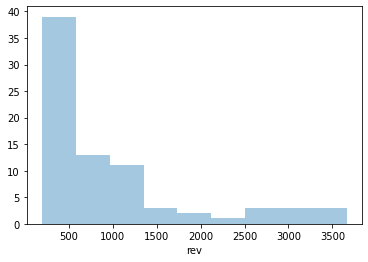

In [13]:
""" Визуализируем график для оценки распределения по группе A"""
sns.distplot(A, kde = False)

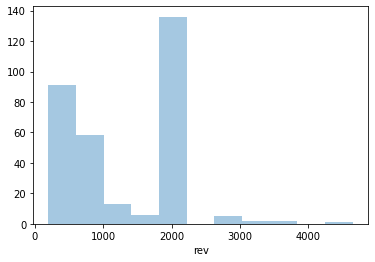

In [14]:
""" Визуализируем график для оценки распределения по группе B"""
sns.distplot(B, kde = False)

Уже даже визуально понятно, что распределение в этих двух группах не нормальное (хотя можно было и прогнать распределение по Шапиро-Уилка),но в данном случае считаю это избыточным. Исходя из этих вводных Т-тест применять не буду

В случае ненормального распределения можно попробовать воспользоваться критерием Манна Уитни, но проблема в интерпретируемости результатов. Этот критерий проверяет только гипотезу о равенстве распределений.

Поэтому для оценки равенства медиан (потому что есть выбросы) буду применять бутстрап

Гипотезы:

H0 - изменение механики оплаты НЕ сказалось на среднем чеке;
H1 - изменение механики оплаты сказалось на среднем чеке;

In [15]:
def get_bootstrap(
    A, # числовые значения первой выборки
    B, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(A), len(B)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = A.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = B.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

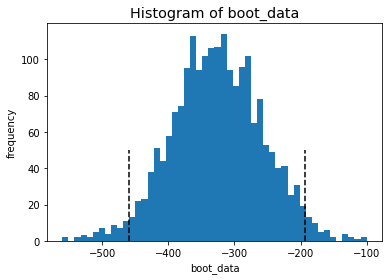

In [16]:
booted_data = get_bootstrap(A, B, boot_it = 2000)

Сравнение средних с помощью бутстрап метода показывает, что между нашими данными есть различия - при вычитании значений из бутстрапированной выборки по группе А значений из выборки по группе В 0 не попадает в доверительный интервал,  следовательно, мы отклоняем нулевую гипотезу о равенстве средних чеков и делаем вывод, что средний чек в тестовой группе значимо выше, чем в контрольной.

Вывод: Cредний чек в тестовой группе имеет значимо более высокие показатели, чем в контрольной, можно запустить новую механику на всех пользователей.

# Задание 2


Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов за март 2020 года.

In [17]:
""" импортируем нужные библиотеки """ 
import pandahouse as ph
import pandas as pd

In [18]:
""" объявляем параметры подключения """ 
connection = dict(database='dev',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [19]:
""" получаем данные из clickhouse в pandas dataframe, считаем данные не за март'20, а за октябрь'21 т.к. в таблице отсутствуют 
данные за нужный период """

query_1 = """
select count(*) as cnt_st
from (

    select 
        st_id,
        sum(correct) as cnt_peas
    from default.peas
    where toStartOfMonth(timest) = '2021-10-01'
    and correct = 1
    group by st_id
    limit 10 ) as base
where base.cnt_peas>=20
"""
df = ph.read_clickhouse(query_1, connection=connection)
df 

,cnt_st
0,4


Ответ: за октябрь 4 очень усердных ученика

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.


Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [20]:
query_2 = """

with base as (
/*ученики - их группа, всего 600 чел*/
select  toInt32(st.st_id) as st_id,
        st.test_grp
from default.studs as st
),

result as (

            /*общая информация по оплатам и правильно решенным задачам*/
                    select base.st_id as st_id,
                            base.test_grp as test_grp,
                            money.money_all as money_all,
                            cnt_peas.cnt_right_peas as cnt_right_peas,
                            money.paid_math as paid_math,
                            cnt_peas.corr_math as cnt_right_math
                            
                    from base 
                    left join (
                                /*сумма оплат по ученикам*/
                                select toInt32(ch.st_id) as st_id,
                                        sum(money) as money_all,
                                        sum(case when money>0 and subject='Math' then 1 else 0 end) as paid_math
                                from default.final_project_check as ch 
                                group by st_id
                                ) as money on money.st_id=base.st_id

                    left join (
                                /*кол-во правильно решенных задач по предметам*/
                                select toInt32(p.st_id) as st_id,
                                        sum(correct) as cnt_right_peas,
                                        sum(case when p.subject='Math' and p.correct>0 then 1 else 0 end) as corr_math
                                from default.peas as p
                                group by p.st_id
                                ) as cnt_peas on cnt_peas.st_id = base.st_id
                    ) 
            
select result.test_grp,

        /*средний доход на 1 пользователя*/
        round(sum(result.money_all) / count(distinct result.st_id),2) as ARPU,
        
        /*средний доход на 1 активного пользователя*/
        round(sum(result.money_all) / sum(case when result.cnt_right_peas>10 then 1 else 0 end),2) as ARPAU,
        
        /*конверсия в покупку = все кто купил / все пользователи */
        round(sum(case when money_all>0 then 1 else 0 end)/ count(distinct result.st_id),2) as CR,
        
        
         /*СR активного пользователя в покупку = купил курс + активный / все активные пользователи */
         round(sum(case when result.money_all>0 and result.cnt_right_peas>10 then 1 else 0 end) / sum(case when result.cnt_right_peas>10 then 1 else 0 end),2) as CR_act,
         
         /*CR для математики = покупка курса по математике / активный пользователь по математике*/
         round(sum(case when result.paid_math>0 and result.cnt_right_math>1 then 1 else 0 end) / sum(case when result.cnt_right_math>1 then 1 else 0 end),2) as CR_math
        
from result
group by result.test_grp
"""            
df_2 = ph.read_clickhouse(query_2, connection=connection)
df_2

,test_grp,ARPU,ARPAU,CR,CR_act,CR_math
0,control,4540.98,10905.51,0.05,0.11,0.06
1,pilot,11508.47,35364.58,0.11,0.26,0.10


# Задание 3

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [21]:
import pandas as pd

In [22]:
def update_metrics(group_add):
    # загружаем все данные
    group_add=pd.read_csv(group_add, sep=',')
    groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/final_project/Проект_2_groups.csv', sep=';')
    active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/final_project/Проект_2_active_studs.csv', ',')
    checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/final_project/Проект_2_checks.csv', ';')
    
    groups_all = pd.concat([groups, group_add])
    # приводим столбцы к одноименному названию
    groups_all = groups_all.rename(columns={'id': 'student_id'})
   
    # оставляем только тех клиентов, которые были активны в дни проведения эксперимента    
    df = active_studs.merge(groups_all, on='student_id', how='left').merge(checks, on='student_id', how='left')

    # рассчитываем конверсии    
    CR_Agroup = ((df.query('grp=="A"').rev.count() / df.query('grp=="A"').student_id.count()) * 100).round(2)
    CR_Bgroup = ((df.query('grp=="B"').rev.count() / df.query('grp=="B"').student_id.count()) * 100).round(2)
    
    # рассчитываем ARPPU для пользователей из группы А 
    ARPPU_A = df.query('grp == "A"').rev.median()

    # рассчитываем ARPPU для пользователей из группы B   
    ARPPU_B = df.query('grp == "B"').rev.median()
    
    # фиксируем показатели в df
    
    data = {'CR': [CR_Agroup, CR_Bgroup], 'ARPPU': [ARPPU_A, ARPPU_B]}
    metrics = pd.DataFrame(data, columns=['CR', 'ARPPU']).reset_index().rename(columns={'index': 'group'})
    
    return metrics

In [23]:
update_metrics('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/final_project/Проект_2_group_add.csv')

,group,CR,ARPPU
0,0,5.07,585.0
1,1,4.62,1140.0


In [24]:
t = update_metrics('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-evsa-22/final_project/Проект_2_group_add.csv')

# Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [25]:
def make_plot(t):
    sns.set(rc={'figure.figsize': (20, 7)})
    fig, ax = plt.subplots(1, 2)
    sns.barplot(x='group', y='CR', data=t, ax=ax[0])
    sns.barplot(x='group', y='ARPPU', data=t, ax=ax[1])

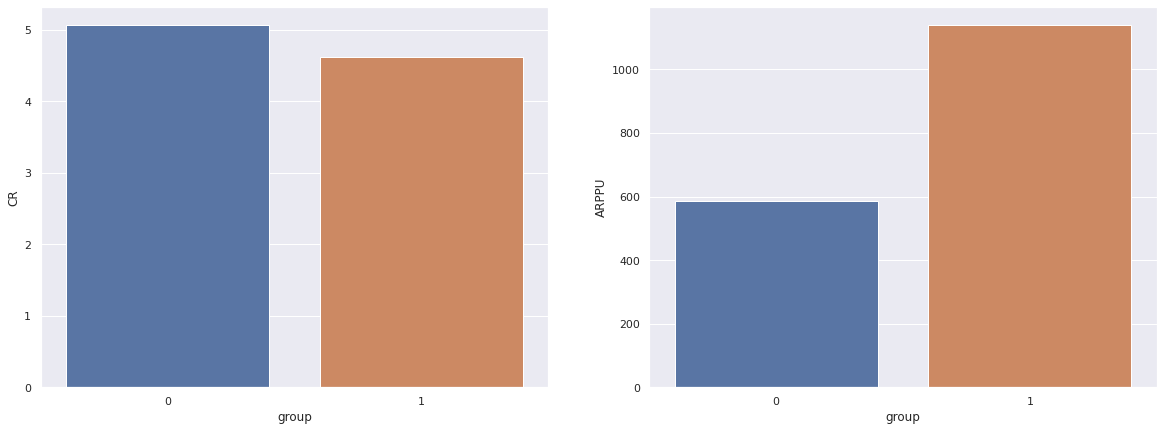

In [26]:
make_plot(t)